In [80]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

## Load Data
This dataset was extracted from the census bureau database found at
http://www.census.gov/ftp/pub/DES/www/welcome.html

The goal is to create a classification model that predict which individuals will have an income greater than 50K and which individuals will have an income less than 50K based on different characteristics such as 'age', 'years of education', 'occupation', 'martial status', etc.

In [2]:
# The code was removed by Watson Studio for sharing.

,Age,work-class,Income,Education,Education_years,Martial_Status,Occupation,Relationship,Race,Gender,Capital_Gain,Capital_Loss,Hours_per_week,Native_country,Class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Peform data exploration

In [3]:
# Here I want to know the shape of the data
df_census.shape

(32561, 15)

In [4]:
# I want to see what the column names
df_census.columns

Index(['Age', 'work-class', 'Income', 'Education', 'Education_years',
       'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Gender',
       'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Native_country',
       'Class'],
      dtype='object')

In [5]:
# I want to know the summary stats for each feature
df_census.describe()

,Age,Income,Education_years,Capital_Gain,Capital_Loss,Hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
# Here I wan to group by years of education and see descriptive stats and distribution for 'Age'
# It's easier to read and analyze

grouped_age = df_census.groupby(['Education_years'])
grouped_age['Age'].describe().unstack()

       Education_years
count  1                     51.000000
       2                    168.000000
       3                    333.000000
       4                    646.000000
       5                    514.000000
       6                    933.000000
       7                   1175.000000
       8                    433.000000
       9                  10501.000000
       10                  7291.000000
       11                  1382.000000
       12                  1067.000000
       13                  5355.000000
       14                  1723.000000
       15                   576.000000
       16                   413.000000
mean   1                     42.764706
       2                     46.142857
       3                     42.885886
       4                     48.445820
       5                     41.060311
       6                     37.429796
       7                     32.355745
       8                     32.000000
       9                     38.974479
  

In [7]:
# I want to analyze at Income and Age 

grouped_age = df_census.groupby(['Education_years'])
grouped_age['Income'].describe().unstack()

       Education_years
count  1                  5.100000e+01
       2                  1.680000e+02
       3                  3.330000e+02
       4                  6.460000e+02
       5                  5.140000e+02
       6                  9.330000e+02
       7                  1.175000e+03
       8                  4.330000e+02
       9                  1.050100e+04
       10                 7.291000e+03
       11                 1.382000e+03
       12                 1.067000e+03
       13                 5.355000e+03
       14                 1.723000e+03
       15                 5.760000e+02
       16                 4.130000e+02
mean   1                  2.358894e+05
       2                  2.393030e+05
       3                  2.324483e+05
       4                  1.880792e+05
       5                  2.024851e+05
       6                  1.968325e+05
       7                  1.949281e+05
       8                  1.990975e+05
       9                  1.895387e+05
  

In [8]:
# I want to take a look at the type of features I'm working with
df_census.dtypes

Age                 int64
work-class         object
Income              int64
Education          object
Education_years     int64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Gender             object
Capital_Gain        int64
Capital_Loss        int64
Hours_per_week      int64
Native_country     object
Class              object
dtype: object

In [9]:
# I want to start cleaning up the data
# Also 'int64' might be unnecessary for 'Hours_per_week', 'Age', and 'Education_years', so I want to change it to 'int32' for computation efficiency

df_census.astype({'Hours_per_week': 'int32', 'Education_years': 'int32', 'Age': 'int16'}).dtypes

Age                 int16
work-class         object
Income              int64
Education          object
Education_years     int32
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Gender             object
Capital_Gain        int64
Capital_Loss        int64
Hours_per_week      int32
Native_country     object
Class              object
dtype: object

In [10]:
# I also noticed that 'Capital Gain' and 'Capital Loss' have quite a few zeros and large standard deviation, which could affect modeling
# One option is to leave them alone and represent reality; however, it may contribute noise
# Another option is to replace the zeros with the mean, which I'm choosing to do

df_census['Capital_Gain']=df_census['Capital_Gain'].replace(0,df_census['Capital_Gain'].mean())
df_census['Capital_Loss']=df_census['Capital_Loss'].replace(0,df_census['Capital_Loss'].mean())
df_census.head()


,Age,work-class,Income,Education,Education_years,Martial_Status,Occupation,Relationship,Race,Gender,Capital_Gain,Capital_Loss,Hours_per_week,Native_country,Class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.000000,87.30383,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,1077.648844,87.30383,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,1077.648844,87.30383,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,1077.648844,87.30383,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,1077.648844,87.30383,40,Cuba,<=50K


In [11]:
# Now I want to examine the summary stats again after adjusting the data
df_census.describe()

,Age,Income,Education_years,Capital_Gain,Capital_Loss,Hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,2065.540504,170.534857,40.437456
std,13.640433,1.055500e+05,2.572720,7245.822677,384.945075,12.347429
min,17.000000,1.228500e+04,1.000000,114.000000,87.303830,1.000000
25%,28.000000,1.178270e+05,9.000000,1077.648844,87.303830,40.000000
50%,37.000000,1.783560e+05,10.000000,1077.648844,87.303830,40.000000
75%,48.000000,2.370510e+05,12.000000,1077.648844,87.303830,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [12]:
# I want to examine feature corellation
# 1 represents perfect positive correlation, using Pearson correlation
# -1 represents perfect negative correlation, using Pearson correlation
corr = df_census.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Age,Income,Education_years,Capital_Gain,Capital_Loss,Hours_per_week
Age,1,-0.077,0.037,0.074,0.058,0.069
Income,-0.077,1,-0.043,0.00064,-0.01,-0.019
Education_years,0.037,-0.043,1,0.12,0.08,0.15
Capital_Gain,0.074,0.00064,0.12,1,-0.029,0.077
Capital_Loss,0.058,-0.01,0.08,-0.029,1,0.054
Hours_per_week,0.069,-0.019,0.15,0.077,0.054,1


In [13]:
df_census.astype({'Hours_per_week': 'int32', 'Education_years': 'int32', 'Age': 'int16', 'Capital_Gain': 'int64', 'Capital_Loss': 'int64'}).dtypes
df_census.dtypes

Age                  int64
work-class          object
Income               int64
Education           object
Education_years      int64
Martial_Status      object
Occupation          object
Relationship        object
Race                object
Gender              object
Capital_Gain       float64
Capital_Loss       float64
Hours_per_week       int64
Native_country      object
Class               object
dtype: object

## Process data for Decision Tree

In [38]:
df_census.head()

,Age,work-class,Income,Education,Education_years,Martial_Status,Occupation,Relationship,Race,Gender,Capital_Gain,Capital_Loss,Hours_per_week,Native_country,Class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.000000,87.30383,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,1077.648844,87.30383,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,1077.648844,87.30383,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,1077.648844,87.30383,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,1077.648844,87.30383,40,Cuba,<=50K


In [100]:
df_census.shape

(32561, 15)

In [51]:
df_census.dtypes

Age                  int64
work-class          object
Income               int64
Education           object
Education_years      int64
Martial_Status      object
Occupation          object
Relationship        object
Race                object
Gender              object
Capital_Gain       float64
Capital_Loss       float64
Hours_per_week       int64
Native_country      object
Class               object
dtype: object

In [63]:
df_census.astype({'Class': 'category'}).dtypes

Age                   int64
work-class           object
Income                int64
Education            object
Education_years       int64
Martial_Status       object
Occupation           object
Relationship         object
Race                 object
Gender               object
Capital_Gain        float64
Capital_Loss        float64
Hours_per_week        int64
Native_country       object
Class              category
dtype: object

In [64]:
df_census['Martial_Status'].unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [97]:
df_census = df_census.replace(to_replace = '?', value = np.nan)

In [98]:
df_census.head()

,Age,work-class,Income,Education,Education_years,Martial_Status,Occupation,Relationship,Race,Gender,Capital_Gain,Capital_Loss,Hours_per_week,Native_country,Class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.000000,87.30383,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,1077.648844,87.30383,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,1077.648844,87.30383,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,1077.648844,87.30383,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,1077.648844,87.30383,40,Cuba,<=50K


In [99]:
df_census.shape

(32561, 15)

In [88]:
df_census['Race'].unique()

array([' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',
       ' Other'], dtype=object)

In [89]:
df_census['Gender'].unique()

array([' Male', ' Female'], dtype=object)

In [90]:
# Create predictors 
X = df_census[['Age', 'Income', 'work-class', 'Education_years', 'Race', 'Gender', 'Occupation', 'Martial_Status']]


In [91]:
X.dtypes

Age                 int64
Income              int64
work-class         object
Education_years     int64
Race               object
Gender             object
Occupation         object
Martial_Status     object
dtype: object

In [92]:
# Get dummies
X = pd.get_dummies(X, prefix_sep='_', drop_first=True)
# X head
X.head()

,Age,Income,Education_years,work-class_ Federal-gov,work-class_ Local-gov,work-class_ Never-worked,work-class_ Private,work-class_ Self-emp-inc,work-class_ Self-emp-not-inc,work-class_ State-gov,...,Occupation_ Protective-serv,Occupation_ Sales,Occupation_ Tech-support,Occupation_ Transport-moving,Martial_Status_ Married-AF-spouse,Martial_Status_ Married-civ-spouse,Martial_Status_ Married-spouse-absent,Martial_Status_ Never-married,Martial_Status_ Separated,Martial_Status_ Widowed
0,39,77516,13,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,38,215646,9,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,234721,7,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,28,338409,13,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [101]:
# Create response vector and covert to np array
y = df_census["Class"]
y[0:5]

0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
Name: Class, dtype: object

In [102]:
# Split the data
from sklearn.model_selection import train_test_split

In [103]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2, random_state=3)

In [104]:
# Shape of trainset
print(X_trainset.shape)
print(y_trainset.shape)

(26048, 36)
(26048,)


## Decision Tree Model

In [106]:
from sklearn.tree import DecisionTreeClassifier

censusTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
censusTree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [107]:
censusTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [109]:
#Prediction
predTree = censusTree.predict(X_testset)

In [110]:
# Compare prediction and actual results
print (predTree [0:5])
print (y_testset [0:5])

[' >50K' ' <=50K' ' <=50K' ' >50K' ' <=50K']
17650      >50K
1002       >50K
11957      >50K
4669       >50K
28486     <=50K
Name: Class, dtype: object


In [111]:
# Evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.8154460310148933


In [130]:
from sklearn.metrics import confusion_matrix

In [132]:
confusion_matrix(y_testset, predTree)

array([[4647,  284],
       [ 918,  664]])

In [135]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

results = confusion_matrix(y_testset, predTree) 
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_testset, predTree))
print ('Report : ')
print (classification_report(y_testset, predTree))


Confusion Matrix :
[[4647  284]
 [ 918  664]]
Accuracy Score : 0.8154460310148933
Report : 
              precision    recall  f1-score   support

       <=50K       0.84      0.94      0.89      4931
        >50K       0.70      0.42      0.52      1582

   micro avg       0.82      0.82      0.82      6513
   macro avg       0.77      0.68      0.71      6513
weighted avg       0.80      0.82      0.80      6513



## Visualize Tree

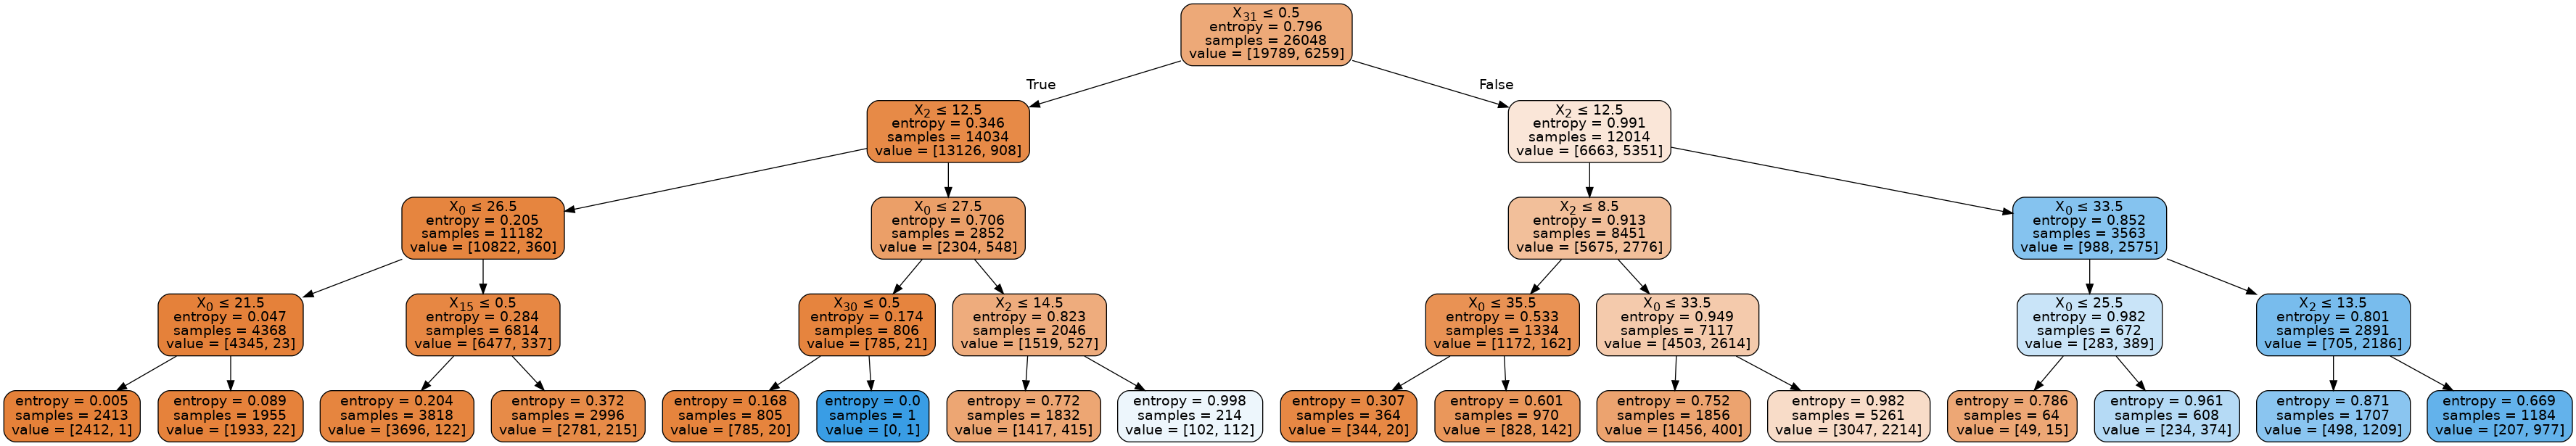

In [142]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(censusTree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())